# Introducción

La clasificación de imágenes se ha vuelto más interesante en el campo de la investigación debido al desarrollo de nuevos frameworks de machine learning de alto rendimiento. Con el avance de las redes neuronales artificiales y el desarrollo de arquitecturas de deep learning, como la red neuronal convolucional (CNN), que se basa en redes neuronales artificiales, se ha disparado el uso y aplicación de la clasificación de imágenes multiclase y el reconocimiento de objetos pertenecientes a múltiples categorías. Cada framework de machine learning tiene una ventaja comparativa sobre los otros, sobre todo los más antiguos, en términos de rendimiento y complejidad. 

En este artículo, implementaremos la clasificación de imágenes multiclase utilizando la red convolucional profunda *VGG-19* como transfer learning framework, donde la *VGGNet* viene preentrenada en el conjunto de datos *ImageNet*. Para el experimento, utilizaremos el conjunto de datos ReDraw y clasificaremos los objetos de imagen en 15 clases. Las precisiones de clasificación del modelo *VGG-19* se visualizarán utilizando las matrices de confusión no normalizadas y normalizadas. 

## ¿Qué es el transfer learning?

El transfer learning es un problema de investigación en el campo del machine learning (aprendizaje automático). Almacena los conocimientos adquiridos al resolver un problema y los aplica a un problema diferente pero relacionado. Por ejemplo, los conocimientos adquiridos mientras se aprende a reconocer gatos podrían aplicarse al intentar reconocer guepardos. En el aprendizaje profundo, el transfer learning es una técnica por la que un modelo de red neuronal se entrena primero en un problema similar al que se está resolviendo. El aprendizaje por transferencia tiene **la ventaja de disminuir el tiempo de entrenamiento de un modelo** de aprendizaje y puede dar lugar a un menor error de generalización.

Esto es importante teniendo en cuenta que en primer lugar intentamos entrenar la CNN desde cero utilizando la estructura propuesta por AlexNet, con un dataset de 102K imágenes de 1200x1920. Lógicamente la capacidad de cómputo de nuestros equipos no fue suficiente para entrenarla y la RAM se llenaba hasta retornar un "crush" en el notebook. Como alternativa, migramos el entorno a Google Colab, pero el resultado fue similar. Tras esto, tuvimos una tutoría en la que se nos abrió una nueva vía gracias al asesoramiento del profesor, el transfer learning. Y es por eso que una buena parte del trabajo tratará de ello.

A continuación veremos cual ha sido la estructura de red que finalmente seleccionamos, debido a que gracias a la reducción del número de parámetros, es más eficiente en el entrenamiento que la que inicialmente fue escogida.

## VGGNet - Deep convolutional network

VGGNet es una deep CNN que fue propuesta por Karen Simonyan y Andrew Zisserman de la Universidad de Oxford en su trabajo de investigación "Very Deep Convolutional Neural Networks for Large-Scale Image Recognition". El nombre de este modelo está inspirado en el nombre de su grupo de investigación "Visual Geometry Group (VGG)". Como esta red neuronal convolucional tiene 19 capas en su arquitectura, se denominó VGG-19. Este modelo se propuso para reducir el número de parámetros de una red neuronal convolucional con un mejor tiempo de entrenamiento. A continuación se muestra el diagrama de bloques de VGG-19 que ilustra su arquitectura.



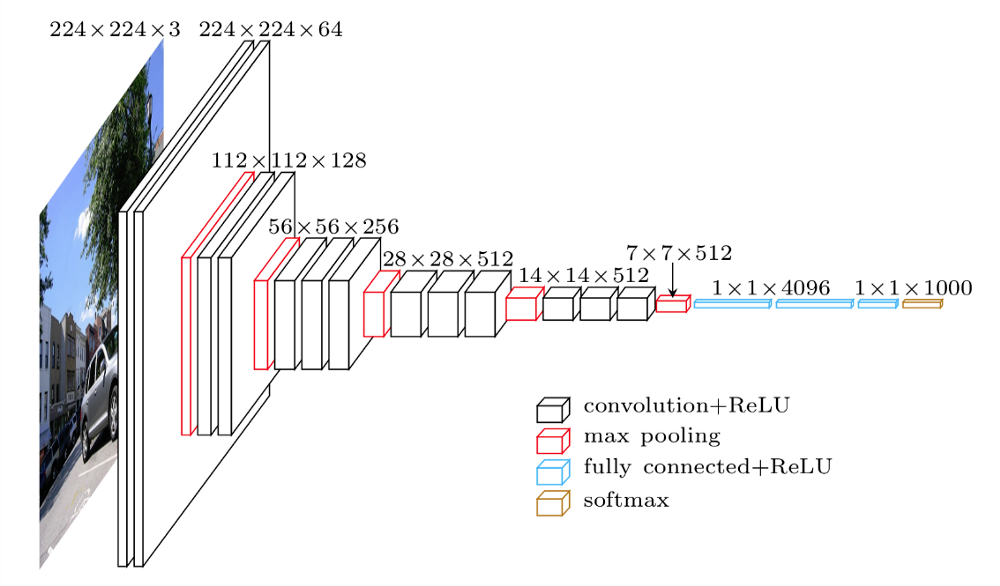

La mayor ventaja de esta red es que se puede cargar una versión preentrenada de la red con más de un millón de imágenes de la base de datos *ImageNet*. Una red preentrenada puede clasificar las imágenes en miles de categorías de objetos. Debido a esta ventaja, vamos a aplicar este modelo en el conjunto de datos de imágenes de ReDraw que tiene 15 categorías de objetos. 


## El Dataset

En este experimento, utilizaremos el conjunto de datos ReDraw, que es un conjunto de datos de imágenes disponible públicamente proporcionado por Zenodo. Consta de 102K imágenes en color de distinta dimensión etiquetadas en 15 clases. Las 15 clases diferentes representan elementos distintos dentro de una interfaz de usuario: ImageView, ImageButton, NumberPicker, RadioButton, SeekBar, CheckBox, ProgressBar, CheckedTextView, ToggleButton, RatingBar, Button, Switch, EditText, TextView, Spinner.

Hay X imágenes de entrenamiento y XX imágenes de prueba en este conjunto de datos.

# Preprocesamiento de los datos

Descargaremos el conjunto de datos de Zenodo.

In [2]:
# Importaciones
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels
import matplotlib.image as mpimg
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Sequential
from keras.applications import VGG19 #For Transfer Learning
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.utils import to_categorical
from PIL import Image
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder

Using TensorFlow backend.


In [2]:
# Carga de contenido de Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Carga de datos

## ReDraw Dataset
Ahora que tenemos creado el modelo según la arquitectura detallada al principio del notebook, vamos a comprobar el rendimiento que tiene en la clasificación. Para esto, vamos a hacer uso del dataset ReDraw, disponible en la plataforma Zenodo. Aunque nosotros lo cargaremos desde nuestro repositorio de github.

In [15]:
# Descargamos el dataset ReDraw de Zenodo
!wget https://zenodo.org/record/2530277/files/CNN-Data-Final.tar.gz -O CNNdata.tgz

--2021-02-21 10:55:46--  https://zenodo.org/record/2530277/files/CNN-Data-Final.tar.gz
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7598237421 (7.1G) [application/octet-stream]
Saving to: ‘CNNdata.tgz’

CNNdata.tgz         100%[===================>]   7.08G  45.7MB/s    in 2m 34s  

2021-02-21 10:58:21 (47.0 MB/s) - ‘CNNdata.tgz’ saved [7598237421/7598237421]



In [16]:
# Descomprimimos el dataset
!tar -xzf CNNdata.tgz

In [132]:
# Vamos a extraer las etiquetas de los nombres de cada imagen. El dataset ya se encuentra dividido en su fuente original por lo que no tendremos que hacer el split.

root = "CNN-Evaluation/Partitioned-Organic-Data-Split/"


data_path = ["Training","Validation","Test"]
dict = {}
df_test = pd.DataFrame([], columns=['height', 'width', 'channels'])

# Ejemplo de nombre de imagen: ._42-android.widget.TextView.png
for path in data_path:
  categories = []
  identifiers = []
  sizes = []
  filenames = []
  for img_filename in os.listdir(root + path):
      if img_filename.endswith(".png"):
          aux = img_filename
          if aux.find('_') == -1:
              s = aux.split('.')[0]
              id = s[:s.find('-')]
              category = img_filename.split('.')[2]
              # Elimino las ProgressBar del dataset porque me aumentan mucho la 
              # dimensión máxima de las imágenes, por lo que tengo que realizar un
              # Zero-pdding demasiado grande posteriormente, teniendo en cuenta que
              # no aporta demasiado valor en el contexto del RPA, ya que casi siempre
              # nos encontraremos con este tipo de componente GUI, por lo que no
              # implicará ninguna característica diferenciadora
              if category.find("ProgressBar") == -1:
                categories.append(category)
                filenames.append(img_filename)
                identifiers.append(id)
                if path == "Test":
                  im = cv2.imread(root + path + "/" + img_filename)
                  h, w, c = im.shape
                  df_test.loc[len(df_test.index)] = [h,w,c]
  dict[path+"_id"] = identifiers
  dict[path+"_filenames"] = filenames
  dict[path+"_labels"] = categories

df_test.to_csv('sizes.csv')

In [136]:
df_test_max = pd.DataFrame(df_test, columns= ['height', 'width'])
df_test_max.head()

,height,width
0,41,60
1,41,1018
2,51,328
3,400,400
4,457,1200


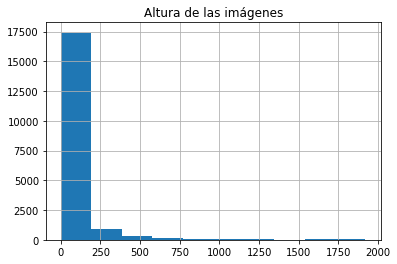

In [137]:
df_test['height'].hist()
plt.title("Altura de las imágenes")
plt.show()

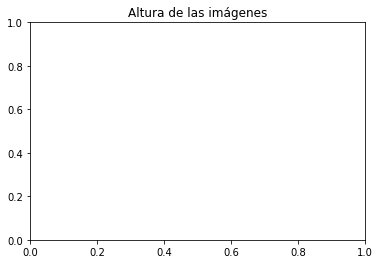

(array([ 296., 5356., 3694., 3890., 2255., 1133.,  426.,  378.,  267.,
         138.]),
 array([0.0, 25.0, 50.0, 75.0, 100.0, 125.0, 150.0, 175.0, 200.0, 225.0,
        250.0], dtype=object),
 <a list of 10 Patch objects>)

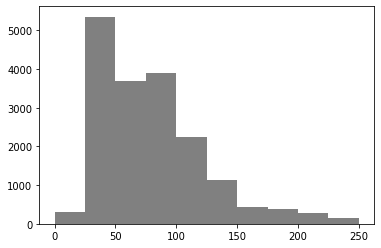

In [138]:
plt.title("Altura de las imágenes")
plt.show()
plt.hist(df_test_max['height'], 10, range=[0, 250], facecolor='gray', align='mid')

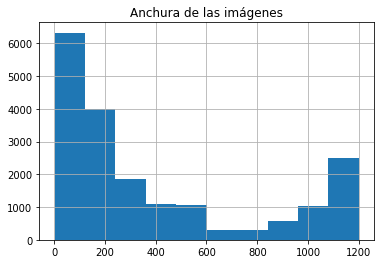

In [139]:
df_test_max['width'].hist()
plt.title("Anchura de las imágenes")
plt.show()

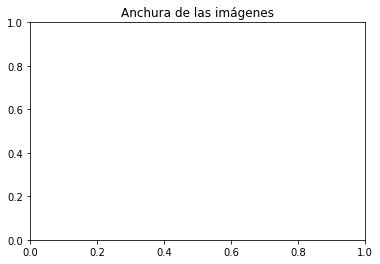

(array([  18.,   95.,  153.,  218.,  319.,  459.,  350.,  742.,  445.,
         563.,  312.,  759.,  532., 1031.,  426.,  636.,  319.,  310.,
         358.,  306.,  272.,  290.,  140.,  312.,  258.,  225.,  152.,
         108.,  215.,  125.]),
 array([0.0, 8.333333333333334, 16.666666666666668, 25.0,
        33.333333333333336, 41.66666666666667, 50.0, 58.333333333333336,
        66.66666666666667, 75.0, 83.33333333333334, 91.66666666666667,
        100.0, 108.33333333333334, 116.66666666666667, 125.00000000000001,
        133.33333333333334, 141.66666666666669, 150.0, 158.33333333333334,
        166.66666666666669, 175.0, 183.33333333333334, 191.66666666666669,
        200.0, 208.33333333333334, 216.66666666666669, 225.00000000000003,
        233.33333333333334, 241.66666666666669, 250.0], dtype=object),
 <a list of 30 Patch objects>)

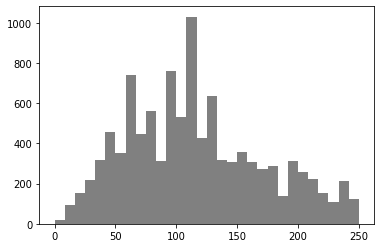

In [140]:
plt.title("Anchura de las imágenes")
plt.show()
plt.hist(df_test_max['width'], 30, range=[0, 250], facecolor='gray', align='mid')

Tras el estudio de los tamaños de las distintas imágenes almacenadas en el dataset, decidimos escoger aquellas que de tamaño menor a 150x150.

In [141]:
filenames.sort()
train_len = len(dict["Training_filenames"])
val_len = len(dict["Validation_filenames"])
test_len = len(dict["Test_filenames"])

print('Ejemplo de filename: '+dict["Training_filenames"][2])
print('¿Cuántas imágenes hay en el conjunto de entrenamiento? - ' + str(train_len))
print('¿Cuántas imágenes hay en el conjunto de validación?    -  ' + str(val_len))
print('¿Cuántas imágenes hay en el conjunto de pruebas?       -  ' + str(test_len))
data_balance = {"Training": {"len": train_len}, "Validation": {"len": val_len}, "Test": {"len": test_len}}

Ejemplo de filename: 51098-android.widget.Button.png
¿Cuántas imágenes hay en el conjunto de entrenamiento? - 142809
¿Cuántas imágenes hay en el conjunto de validación?    -  28557
¿Cuántas imágenes hay en el conjunto de pruebas?       -  19047


In [142]:
print('¿Entre cuántas clases puedo clasificar los componentes? - ' + str(len(classes_distinct)))
classes_distinct = list(set(dict["Training_labels"]))
classes_distinct

¿Entre cuántas clases puedo clasificar los componentes? - 13


['RatingBar',
 'ToggleButton',
 'NumberPicker',
 'Spinner',
 'Switch',
 'CheckBox',
 'TextView',
 'EditText',
 'ImageButton',
 'CheckedTextView',
 'SeekBar',
 'ImageView',
 'RadioButton',
 'Button']

,Training_labels,Validation_labels,Test_labels
0,ImageView,RadioButton,TextView
1,TextView,ImageView,TextView
2,Button,TextView,TextView
3,TextView,ImageView,ImageView
4,ImageButton,ImageView,ImageView


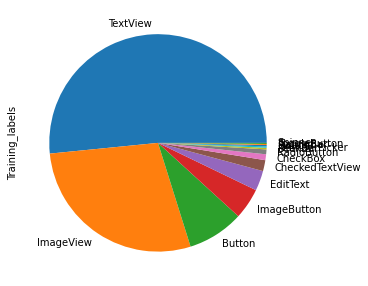

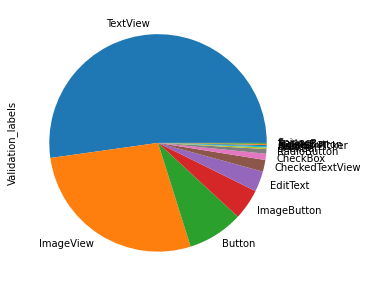

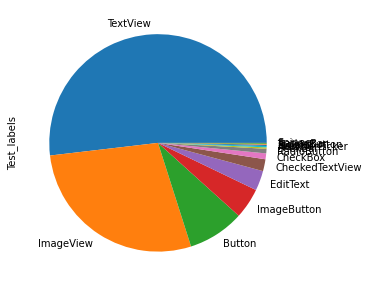

In [143]:
df = pd.DataFrame(list(zip(dict["Training_labels"], dict["Validation_labels"], dict["Test_labels"])), columns =['Training_labels','Validation_labels','Test_labels'])
fig = plt.figure(figsize=(5,5))
frec_weather = df["Training_labels"].value_counts()
frec_weather.plot(kind='pie')
fig = plt.figure(figsize=(5,5))
frec_weather = df["Validation_labels"].value_counts()
frec_weather.plot(kind='pie')
fig = plt.figure(figsize=(5,5))
frec_weather = df["Test_labels"].value_counts()
frec_weather.plot(kind='pie')
df.head()

In [144]:
for label in classes_distinct:
  data_balance["Training"][label] = dict["Training_labels"].count(label)
  data_balance["Validation"][label] = dict["Validation_labels"].count(label)
  data_balance["Test"][label] = dict["Test_labels"].count(label)
df_balance = df['Training_labels'].value_counts(normalize=True).to_frame()
df_balance = df_balance.add(df['Validation_labels'].value_counts(normalize=True).to_frame(), fill_value=0)
df_balance = df_balance.add(df['Test_labels'].value_counts(normalize=True).to_frame(), fill_value=0)

In [145]:
df_balance

,Test_labels,Training_labels,Validation_labels
Button,0.084003,0.083793,0.082848
CheckBox,0.008663,0.008715,0.009240
CheckedTextView,0.017693,0.016276,0.017378
EditText,0.029558,0.029821,0.030503
ImageButton,0.045466,0.046202,0.045519
ImageView,0.280622,0.282722,0.276369
NumberPicker,0.001995,0.002100,0.001785
RadioButton,0.006773,0.007193,0.006878
RatingBar,0.001155,0.001575,0.001313
SeekBar,0.002100,0.002363,0.002363


In [146]:
data_balance

{'Test': {'Button': 1600,
  'CheckBox': 165,
  'CheckedTextView': 337,
  'EditText': 563,
  'ImageButton': 866,
  'ImageView': 5345,
  'NumberPicker': 38,
  'RadioButton': 129,
  'RatingBar': 22,
  'SeekBar': 40,
  'Spinner': 2,
  'Switch': 37,
  'TextView': 9877,
  'ToggleButton': 26,
  'len': 19047},
 'Training': {'Button': 12007,
  'CheckBox': 1238,
  'CheckedTextView': 2528,
  'EditText': 4230,
  'ImageButton': 6521,
  'ImageView': 39983,
  'NumberPicker': 283,
  'RadioButton': 970,
  'RatingBar': 164,
  'SeekBar': 304,
  'Spinner': 15,
  'Switch': 280,
  'TextView': 74087,
  'ToggleButton': 199,
  'len': 142809},
 'Validation': {'Button': 2400,
  'CheckBox': 247,
  'CheckedTextView': 505,
  'EditText': 846,
  'ImageButton': 1306,
  'ImageView': 7996,
  'NumberPicker': 57,
  'RadioButton': 194,
  'RatingBar': 33,
  'SeekBar': 61,
  'Spinner': 3,
  'Switch': 56,
  'TextView': 14813,
  'ToggleButton': 40,
  'len': 28557}}

In [148]:
# Estudiamos cuál ha sido la 
max_height = df_test['height'].max()
max_width = df_test['width'].max()
print('Max height ' + str(max_height))
print('Max width ' + str(max_width))

Max height 1920
Max width 1200


Al ser una CNN que consta de Fully Connected Layers, todas las imágenes de entrada deben de tener la misma dimensión. Para que no afecte a los resultados el [resizing](https://ai.stackexchange.com/questions/6274/how-can-i-deal-with-images-of-variable-dimensions-when-doing-image-segmentation) de la imagen estudiamos varias alternativas como el tipo de interpolacion ***Nearest Neighbour Interpolation*** y el ***Zero-padding***, finalmente tras encontrar el apoyo de la [literatura](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0263-7) para la aplicación del Zero-padding en el caso específico de las CNN, seleccionamos esta última.

In [149]:
# Zero-padding
def pad(img, h, w):
    #  in case when you have odd number
    top_pad = np.floor((h - img.shape[0]) / 2).astype(np.uint16)
    bottom_pad = np.ceil((h - img.shape[0]) / 2).astype(np.uint16)
    right_pad = np.ceil((w - img.shape[1]) / 2).astype(np.uint16)
    left_pad = np.floor((w - img.shape[1]) / 2).astype(np.uint16)
    return np.copy(np.pad(img, ((top_pad, bottom_pad), (left_pad, right_pad), (0, 0)), mode='constant', constant_values=0))

# Creamos el directorio donde vamos a almacenar las imagenes tras aplicarles el zero-padding

# !mkdir Preprocessed_data_Training
# !mkdir Preprocessed_data_Validation
# !mkdir Preprocessed_data_Test

# for path in data_path:
#   df = pd.DataFrame([], columns=['height', 'width', 'channels'])
#   for img_filename in dict[path + '_filenames']:
#     if img_filename.endswith(".png"):
#       aux = img_filename
#       if aux.find('_') == -1:
#         s = root + path + "/" + img_filename
#         im = cv2.imread(s)
#         h, w, c = im.shape
#         df.loc[len(df.index)] = [h,w,c]
#         img_original = cv2.imread(s)
#         assert not isinstance(img_original,type(None)), img_filename + ': image not found'
#         img_padded = pad(img_original, 1920, 1200)
#         cv2.imwrite("Preprocessed_data" + path + "/" + img_filename, img_padded)
#         #resized_image = cv2.resize(s, (227, 227), interpolation=cv2.INTER_NEAREST)

# df.to_csv( path +'_Sizes.csv')

Teniendo en cuenta el análisis mostrado sobre los datos, se puede extraer que el dataset disponible en ReDraw es ideal para constar de recursos con potencia computacional para aprovechar el conocimiento recogido en él. El problema es que tras intentar entrenar la CNN con los conjuntos previamente mostrados, hemos visto que es inviable en los equipos de los que disponemos. Incluso probamos a migrar a Google colaboratory, pero siguió sobrepasando la capacidad de los recursos que nos proporcionaba. Por eso, cogeremos el conjunto de datos de test, que comprende 19K imágenes, de las que extraeremos nuestros propios conjuntos de entrenamiento, validación y pruebas, para que sea un tamaño más manejable.

Además reajustaremos el tamaño de las imágenes de 150x150 a 50x50 mediante la librería Tensorflow para minimizar aún más el tiempo de entrenamiento de la red posteriormente.

In [162]:
# creamos el directorio donde vamos a almacenar las imagenes tras aplicarles el zero-padding
!mkdir preprocessed_data_resized


# Como se he detallado en el estudio soportado por los histogramas, escogeremos
# las imagenes que sean de dimension 150x150 o menores y les aplicaremos el Zero-padding
max_height = 150
max_width = 150

X_rez = []
y_rez = []

for index, img_filename in enumerate(dict['Test_filenames'], start=0): 
  if img_filename.endswith(".png"):
    aux = img_filename
    if aux.find('_') == -1:
      s = root + "Test/" + img_filename
      im = cv2.imread(s)
      h, w, c = im.shape
      if h < max_height and w < max_width:
        img_original = cv2.imread(s)
        assert not isinstance(img_original,type(None)), img_filename + ': image not found'
        img_padded = pad(img_original, max_height, max_width)
        cv2.imwrite("preprocessed_data_resized/" + img_filename, img_padded)
        img_resized = tf.image.resize(img_padded, [50,50], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR, preserve_aspect_ratio=True,antialias=True)
        X_rez.append(img_resized)
        y_rez.append(dict["Test_labels"][index])
        #resized_image = cv2.resize(s, (50, 50), interpolation=cv2.INTER_NEAREST)

mkdir: cannot create directory ‘preprocessed_data_resized’: File exists


In [163]:
print(len(X_rez))
print(len(y_rez))

7557
7557


In [164]:
arr = np.array(X_rez)
arr_labels = np.array(y_rez)
np.save("preprocessed_50_50.npy", arr)
np.save("test_labels.npy", arr_labels)

In [166]:
# Como se he detallado en el estudio soportado por los histogramas, escogeremos
# las imagenes que sean de dimension 150x150 o menores y les aplicaremos el Zero-padding
max_height = 150
max_width = 150
y_balance = []
X_balance = []

freq = {'SeekBar': {'len': 0}, 'NumberPicker': {'len': 0}, 'RatingBar': {'len': 0}, 'ToggleButton': {'len': 0}, 'Spinner': {'len': 0}, 'Switch': {'len': 0}, 'CheckBox': {'len': 0}, 'EditText': {'len': 0}, 'ImageButton': {'len': 0}, 'CheckedTextView': {'len': 0}, 'RadioButton': {'len': 0}, 'Button': {'len': 0}}

datasets = ["Training", "Validation"]
for dataset in datasets:
  for index, lab in enumerate(dict[dataset + '_labels'], start=0): 
    if (lab != "TextView" and lab != "ImageView") and (freq[lab]["len"] < 3000):
      img_filename = dict[dataset + '_filenames'][index]
      if img_filename.endswith(".png")  and img_filename.find('_') == -1:
        s = root + dataset + "/" + img_filename
        im = cv2.imread(s)
        h, w, c = im.shape
        if h < 150 and w < 150:
          img_original = cv2.imread(s)
          assert not isinstance(img_original,type(None)), img_filename + ': image not found'
          img_padded = pad(img_original, max_height, max_width)
          cv2.imwrite("preprocessed_data_resized/" + img_filename, img_padded)
          img_resized = tf.image.resize(img_padded, [50,50], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR, preserve_aspect_ratio=True,antialias=True)
          X_balance.append(img_resized)
          y_balance.append(lab)
          freq[lab]["len"] = freq[lab]["len"] + 1

In [167]:
print("y_balance len: "+str(len(y_balance)))
print("X_balance len: "+str(len(X_balance)))

y_balance len: 8225
X_balance len: 8225


In [168]:
print("arr_labels len: "+str(len(arr_labels)))
print("arr len: "+str(len(arr)))

arr_labels len: 7557
arr len: 7557


In [169]:
arr_balance = np.vstack((arr, np.array(X_balance)))

In [170]:
arr_labels_balance = np.append(arr_labels, y_balance)

In [171]:
print("arr_labels len: "+str(len(arr_labels_balance)))
print("arr len: "+str(len(arr_balance)))

arr_labels len: 15782
arr len: 15782


In [172]:
np.save("preprocessed_50_50_balance.npy", arr_balance)
np.save("test_labels_balance.npy", arr_labels_balance)

Almacenamiento de las imágenes con Zero-padding aplicado

In [ ]:
#@title Guardar datos en Drive
filename = "Preprocessed_data_Test_150_150" #@param {type:"string"}
folders_or_files_to_save = "preprocessed_data_150_150" #@param {type:"string"}
from google.colab import files
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

def save_file_to_drive(name, path):
    file_metadata = {
    'name': name,
    'mimeType': 'application/octet-stream'
    }

    media = MediaFileUpload(path, 
                  mimetype='application/octet-stream',
                  resumable=True)

    created = drive_service.files().create(body=file_metadata, media_body=media, fields='id').execute()

    print('File ID: {}'.format(created.get('id')))

    return created


extension_zip = ".zip"

zip_file = filename + extension_zip

# !rm -rf $zip_file
!zip -r $zip_file {folders_or_files_to_save} # FOLDERS TO SAVE INTO ZIP FILE

auth.authenticate_user()
drive_service = build('drive', 'v3')

destination_name = zip_file
path_to_file = zip_file
save_file_to_drive(destination_name, path_to_file)

Streaming output truncated to the last 5000 lines.
  adding: preprocessed_data_150_150/84810-android.widget.TextView.png (deflated 8%)
  adding: preprocessed_data_150_150/8324-android.widget.TextView.png (deflated 20%)
  adding: preprocessed_data_150_150/179207-android.widget.ImageButton.png (deflated 25%)
  adding: preprocessed_data_150_150/55316-android.widget.ImageView.png (deflated 17%)
  adding: preprocessed_data_150_150/54771-android.widget.TextView.png (deflated 25%)
  adding: preprocessed_data_150_150/123546-android.widget.TextView.png (deflated 28%)
  adding: preprocessed_data_150_150/190987-android.widget.TextView.png (deflated 58%)
  adding: preprocessed_data_150_150/124342-android.widget.ImageView.png (deflated 49%)
  adding: preprocessed_data_150_150/142072-android.widget.ImageView.png (deflated 11%)
  adding: preprocessed_data_150_150/55148-android.widget.ImageView.png (deflated 18%)
  adding: preprocessed_data_150_150/149053-android.widget.ImageButton.png (deflated 25%)


{'id': '11-drAb3tMzA_ZmPVbjbs4BlEZCL5_VJO'}

# Prueba de concepto

Importaremos el resto de librerías que van a ser necesarias en nuestro experimento.

In [ ]:
#importing other required libraries


Para trabajar diariamente con este problema, ya que migramos el código a Google Colab para aprovechar su potencia, hemos integrado el notebook con Google Drive para que los datos preprocesados (con el Zero-Padding aplicado) se almacenen y no sea necesario ejecutar de nuevo todas las celdas anteriores, ahorrando un tiempo considerable. Esto se debe a que Google Colab mata a la sesión periódcamente, y los archivos no se persisten.

A continuación vemos como accedemos a los archivos almacenados en Drive y extraemos las etiquetas.

In [106]:
arr = np.load('/content/drive/MyDrive/preprocessed_50_50.npy')
arr_labels = np.load('/content/drive/MyDrive/test_labels.npy')

In [107]:
print('¿Cuántas imágenes hay en el conjunto de datos? - ' + str(len(arr_labels)))

¿Cuántas imágenes hay en el conjunto de datos? - 14927


In [108]:
classes_distinct = list(set(arr_labels))
classes_distinct
print('¿Entre cuántas clases puedo clasificar los componentes? - ' + str(len(classes_distinct)))
print(classes_distinct)

¿Entre cuántas clases puedo clasificar los componentes? - 13
['RatingBar', 'ToggleButton', 'Spinner', 'Switch', 'CheckBox', 'TextView', 'EditText', 'ImageButton', 'CheckedTextView', 'SeekBar', 'ImageView', 'RadioButton', 'Button']


Nos damos cuenta que con la reducción del dataset a aquellas imagenes que son menores de 150x150 perdemos las clases NumberPicker y SeekBar. Vamos a realizar un análisis para ver el nivel de desbalanceo existeinte.

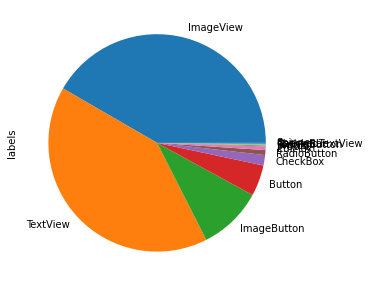

In [7]:
df = pd.DataFrame(list(arr_labels), columns = ["labels"])
fig = plt.figure(figsize=(5,5))
frec_weather = df["labels"].value_counts()
frec_weather.plot(kind='pie')

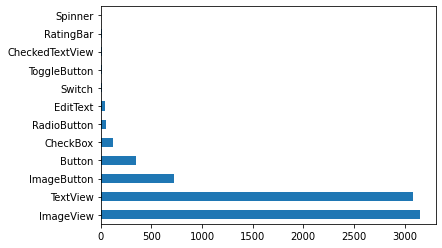

In [10]:
b = df["labels"].value_counts()
b.plot.barh()

In [13]:
b

ImageView          3148
TextView           3084
ImageButton         724
Button              349
CheckBox            117
RadioButton          55
EditText             41
Switch               11
ToggleButton         11
CheckedTextView       8
RatingBar             8
Spinner               1
Name: labels, dtype: int64

Observamos que hay un desbalanceo claro entre las clases del dataset, por ello se llevó a cabo un segundo procesamiento, en el que se accede al resto de datos disponibles en ReDraw para balancear el dataset lo máximo posible.

In [4]:
arr_balance = np.load('preprocessed_50_50_balance.npy')
arr_labels_balance = np.load('test_labels_balance.npy')

<AxesSubplot:ylabel='labels'>

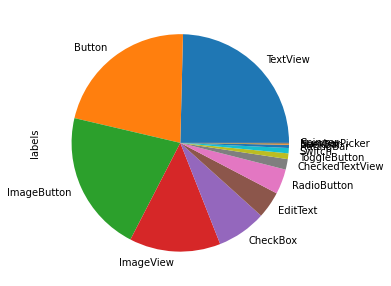

In [5]:
df = pd.DataFrame(list(arr_labels_balance), columns = ["labels"])
fig = plt.figure(figsize=(5,5))
frec_weather = df["labels"].value_counts()
frec_weather.plot(kind='pie')

<AxesSubplot:>

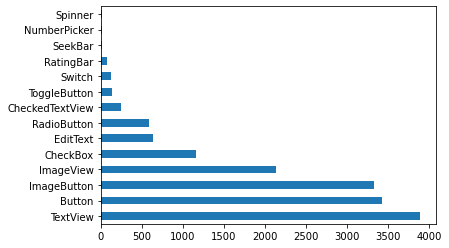

In [6]:
b = df["labels"].value_counts()
b.plot.barh()

Aquí, dividiremos el conjunto de datos descargados en conjuntos de entrenamiento, prueba y validación.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(arr_balance, arr_labels_balance, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [8]:
x_train = np.array(X_train)
x_val = np.array(X_val)
x_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [9]:
# X = np.array(list(Image.open(data_path + "/" + dict['Test_filenames'][0]).getdata()))

# for i in range(1, len(dict['Test_filenames'])):
#     img_pixels = list(Image.open(data_path + "/" + dict['Test_filenames'][i]).getdata())
#     X = np.vstack((X, img_pixels))

Una vez divididos, veremos la forma de nuestros datos. Deberá ser la misma que se indica en la descripción del conjunto de datos en su sitio web principal.

Tenemos que hacer una codificación one hot porque tenemos 15 clases y debemos esperar que la forma de y_train,y_val y y_test cambie de 1 a 15

In [10]:
#One Hot Encoding
onehot_encoder = OneHotEncoder(sparse=False)
y_train = y_train.reshape(len(y_train), 1)
y_train = onehot_encoder.fit_transform(y_train)
y_val = y_val.reshape(len(y_val), 1)
y_val = onehot_encoder.fit_transform(y_val)
y_test = y_test.reshape(len(y_test), 1)
y_test = onehot_encoder.fit_transform(y_test)


Tras el one hot encoding, nos aseguraremos de haber obtenido la forma deseada.

In [11]:
#Verifying the dimension after one hot encoding
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((9468, 50, 50, 3), (9468, 14))
((3157, 50, 50, 3), (3157, 14))
((3157, 50, 50, 3), (3157, 14))


Aquí realizaremos el *data augmentation*. Esta es la técnica que se utiliza para ampliar el tamaño de un conjunto de datos de entrenamiento creando versiones modificadas de las imágenes del conjunto de datos. En primer lugar, definiremos instancias individuales de ImageDataGenerator para el aumento y luego las ajustaremos con cada uno de los conjuntos de datos de entrenamiento, prueba y validación. 

In [12]:
#Image Data Augmentation
train_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1)

val_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1)

test_generator = ImageDataGenerator(rotation_range=2, horizontal_flip= True, zoom_range=.1)

#Fitting the augmentation defined above to the data
train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

En este experimento utilizaremos el *learning rate annealer*. El *learning rate annealer* disminuye la tasa de aprendizaje después de un cierto número de *epochs* si la tasa de error no cambia. Aquí, a través de esta técnica, vamos a controlar la precisión de validación y si parece ser una meseta en 3 épocas, se reducirá la tasa de aprendizaje en 0,01.

In [13]:
#Learning Rate Annealer
lrr= ReduceLROnPlateau(monitor='val_acc', factor=.01, patience=3, min_lr=1e-5)

Ahora, instanciaremos la deep convolutional neural network (CNN), la VGG-19, como un modelo de transfer learning.

# VGG19 como una Deep Convolutional Neural Network

In [14]:
#Defining the VGG Convolutional Neural Net
base_model = VGG19(include_top = False, weights = 'imagenet', input_shape = (50,50,3), classes = y_train.shape[1])

80142336/80134624 [==============================] - 3s 0us/step


Ahora, definiremos VGG19 como una arquitectura de aprendizaje profundo. Para ello, se definirá como un modelo secuencial de Keras con varias *dense layers*. 

In [15]:
#Adding the final layers to the above base models where the actual classification is done in the dense layers
model= Sequential()
model.add(base_model) 
model.add(Flatten()) 

Ahora, para añadir más capas, necesitamos ver la dimensión de nuestro modelo.

In [16]:
#Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
Total params: 20,024,384
Trainable params: 20,024,384
Non-trainable params: 0
_________________________________________________________________


In [17]:
#Adding the Dense layers along with activation and batch normalization
model.add(Dense(1024,activation=('relu'),input_dim=512))
model.add(Dense(512,activation=('relu'))) 
model.add(Dense(256,activation=('relu'))) 
model.add(Dropout(.3))
model.add(Dense(128,activation=('relu')))
#model.add(Dropout(.2))
model.add(Dense(14,activation=('softmax'))) 

#Checking the final model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

Como hemos definido nuestro modelo, ahora tenemos que inicializar los hiperparámetros necesarios para entrenar el modelo y, finalmente, compilaremos nuestro modelo.

In [18]:
#Initializing the hyperparameters
batch_size= 32
epochs=20
learn_rate=.001
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

Ahora, empezamos a entrenar nuestro VGG10, el modelo de red neuronal convolucional profunda.

In [19]:
#Training the model
model.fit_generator(train_generator.flow(x_train, y_train, batch_size= batch_size),epochs = epochs, steps_per_epoch = x_train.shape[0]//batch_size, validation_data = val_generator.flow(x_val, y_val, batch_size = batch_size), validation_steps = 250, callbacks=[lrr], verbose = 1)

Epoch 1/20
295/295 [==============================] - 613s 2s/step - loss: 2.0916 - accuracy: 0.2735 - val_loss: 1.7229 - val_accuracy: 0.4036
Epoch 2/20


C:\Users\Antonio\.conda\envs\MLE\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


295/295 [==============================] - 600s 2s/step - loss: 1.6570 - accuracy: 0.4156 - val_loss: 1.3703 - val_accuracy: 0.4704
Epoch 3/20
295/295 [==============================] - 598s 2s/step - loss: 1.5334 - accuracy: 0.4656 - val_loss: 1.5017 - val_accuracy: 0.4907
Epoch 4/20
295/295 [==============================] - 574s 2s/step - loss: 1.4443 - accuracy: 0.4985 - val_loss: 1.4990 - val_accuracy: 0.4999
Epoch 5/20
295/295 [==============================] - 571s 2s/step - loss: 1.3680 - accuracy: 0.5299 - val_loss: 1.6256 - val_accuracy: 0.5196
Epoch 6/20
295/295 [==============================] - 572s 2s/step - loss: 1.3303 - accuracy: 0.5362 - val_loss: 1.1054 - val_accuracy: 0.5088
Epoch 7/20
295/295 [==============================] - 575s 2s/step - loss: 1.2954 - accuracy: 0.5489 - val_loss: 1.5727 - val_accuracy: 0.5333
Epoch 8/20
295/295 [==============================] - 571s 2s/step - loss: 1.2748 - accuracy: 0.5597 - val_loss: 1.4641 - val_accuracy: 0.5513
Epoch 9/20

Como podemos ver en la imagen anterior, hemos conseguido una precisión de entrenamiento del 99,22% y una precisión de validación del 85,41%. Ahora vamos a visualizar la precisión y la pérdida durante el entrenamiento.

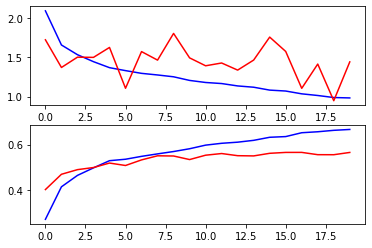

In [20]:
#Plotting the training and validation loss and accuracy
f,ax=plt.subplots(2,1) 

#Loss
ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

#Accuracy
ax[1].plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')

In [31]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


Haremos predicciones de clases de imágenes mediante este modelo utilizando el conjunto de datos de prueba.

In [25]:
#Making prediction
y_pred=model.predict_classes(x_test)
y_true=np.argmax(y_test,axis=1)

# Rendimiento de VGG19 - La red neuronal convolucional profunda

Por último, visualizaremos el rendimiento de la clasificación en los datos de prueba utilizando las matrices de confusión. 

In [28]:
#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    #Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')


    #Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

Primero veremos el número exacto de clasificaciones correctas e incorrectas utilizando la matriz de confusión no normalizada y luego veremos lo mismo en porcentaje utilizando la matriz de confusión normalizada. 

Confusion matrix, without normalization


<AxesSubplot:title={'center':'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

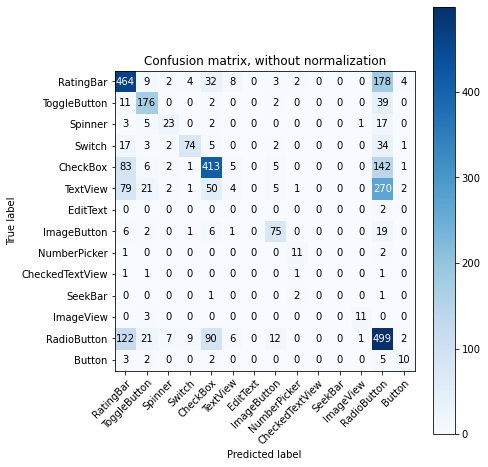

In [32]:
#Plotting the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

#Defining the class labels
class_names=['RatingBar', 'ToggleButton', 'Spinner', 'Switch', 'CheckBox', 'TextView', 'EditText', 'ImageButton', 'NumberPicker', 'CheckedTextView', 'SeekBar', 'ImageView', 'RadioButton', 'Button']

# Plotting non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes = class_names, title='Confusion matrix, without normalization')


Confusion matrix, without normalization


<AxesSubplot:title={'center':'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

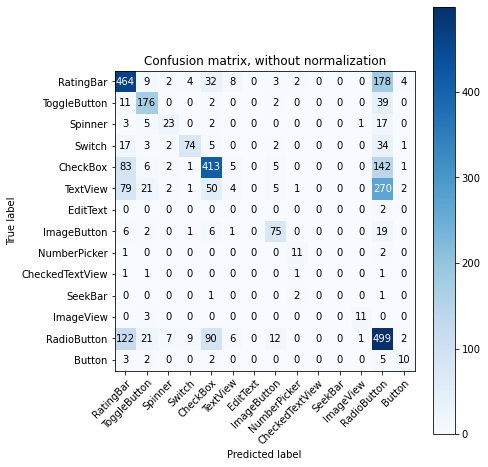

In [34]:
#Plotting the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

#Defining the class labels
class_names=['RatingBar', 'ToggleButton', 'Spinner', 'Switch', 'CheckBox', 'TextView', 'EditText', 'ImageButton', 'NumberPicker', 'CheckedTextView', 'SeekBar', 'ImageView', 'RadioButton', 'Button']

# Plotting non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes = class_names, title='Confusion matrix, without normalization')


Como podemos ver al clasificar las imágenes en 10 clases, el modelo ha dado una precisión mínima del 72% y una máxima del 95%. Podemos seguir ajustando los parámetros de entrenamiento y volver a entrenar nuestro modelo para ver cualquier posible mejora en la clasificación. Pero lo que hemos obtenido en este experimento es el estándar. De 10 clases, ha dado menos del 80% de precisión en la clasificación de sólo 3 clases y ha dado más del 90% de precisión en la clasificación de imágenes de 15 clases. 

In [36]:
from keras.models import model_from_json
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])
score = loaded_model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 55.75%
